In [77]:
import matplotlib.pyplot as plt

In [1]:
import time

import numpy as np

from portiloop_software.portiloop_python.ANN.utils import get_configs

from portiloop_software.portiloop_python.ANN.data.mass_data import read_pretraining_dataset, read_sleep_staging_labels, read_spindle_trains_labels
from portiloop_software.portiloop_python.ANN.models.lstm import get_trained_model
import torch


experiment_name = 'test_adapation'
seed = 42
model_path = 'no_att_baseline'
subject_id = '01-02-0019'

config = get_configs(experiment_name, False, seed)
# config['nb_conv_layers'] = 4
# config['hidden_size'] = 64
# config['nb_rnn_layers'] = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = get_trained_model(config, config['path_models'] / model_path)

# Run some testing on subject 1
# Load the data
labels = read_spindle_trains_labels(config['old_dataset'])
ss_labels = read_sleep_staging_labels(config['path_dataset'])
# for index, patient_id in enumerate(ss_labels.keys()):

config['subject_id'] = subject_id

data = read_pretraining_dataset(config['MASS_dir'], patients_to_keep=[subject_id])

/project/portiloop-training/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


558


In [2]:
import torch

class DataBuffer:
    """
    A class to get the data in the right format for the model from a stream of data
    """
    def __init__(self, seq_len, window_size, seq_stride):
        self.seq_len = seq_len
        self.window_size = window_size
        self.seq_stride = seq_stride

        # Compute the total number of points to keep in memory as the buffer
        buffer_size = (seq_len - 1) * seq_stride + window_size
        self.data = torch.zeros(buffer_size, dtype=torch.float32)

    def step(self, point):
        # Shift the data
        self.data[:-1] = self.data.clone()[1:]
        self.data[-1] = point
        current_data = self.data.clone().unfold(0, self.window_size, self.seq_stride)
        current_data = current_data.unsqueeze(0).unsqueeze(2)
        return current_data

In [199]:
from torch.utils.data import Dataset
from portiloop_software.portiloop_python.ANN.utils import RMSScorer
import random

class AdaptationSampler(torch.utils.data.Sampler):
    def __init__(self, dataset):
        """
        Sample random items from a dataset
        """
        self.dataset = dataset

    def __iter__(self):
        """
        Returns an iterator over the dataset
        """
        while True:
            toss = random.random()
            if toss > 0.5:
                # Get a random index from the spindle indexes
                yield 1
            else:
                yield 0


class AdapatationDatasetRMS(Dataset):
    """
    Dataset for adaptation using the RMS score metric. 
    """
    def __init__(self, seq_len, window_size, seq_stride, replacement=False, candidate_threshold=1, rms_threshold=3, negative_rms_threshold=0.5, buffer_time=1250):
        self.buffer_time = buffer_time # 5 seconds: time before and after each window for the RMS
        self.buffer_size = max(seq_len * window_size, self.buffer_time) + self.buffer_time
        self.data = []
        self.labels = []
        self.seq_len = seq_len
        self.window_size = window_size
        self.seq_stride = seq_stride
        self.candidate_threshold = candidate_threshold
        self.rms_threshold = rms_threshold
        self.negative_rms_threshold = negative_rms_threshold
        self.scorer = RMSScorer()

        self.replacement = replacement

        self.max_samples_len = 1000

        self.interval = 100 # 400 ms
        self.real_index = seq_len * seq_stride
        self.real_indexes = []

        # List of samples
        self.positive_samples = []
        self.negative_samples = []
        # self.spindle_indexes = []
        # self.non_spindle_indexes = []

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        '''
        Returns a sample from the dataset. If replacement is True, the sample is not removed from the dataset.
        '''
        # Choose a random index in one of the lists
        list_to_sample = self.positive_samples if index == 1 else self.negative_samples

        index_in_list = random.randint(0, len(list_to_sample)-1)

        sample = list_to_sample[index_in_list] if self.replacement else list_to_sample.pop(index_in_list)

        return sample[0].float(), index, sample[1]
    
    def spindle_percentage(self):
        sum_spindles = sum([i[1] for i in self.samples if i[1] == 1])
        return sum_spindles / len(self)

    def add_sample(self, sample, label):
        """
        Takes a sample and adds it to the dataset.
        """
        if label == 1:
            if len(self.positive_samples) >= self.max_samples_len:
                self.positive_samples[random.randint(0, len(self.positive_samples)-1)] = sample
            else:
                self.positive_samples.append(sample)
        else:
            if len(self.negative_samples) >= self.max_samples_len:
                self.negative_samples[random.randint(0, len(self.negative_samples)-1)] = sample
            else:
                self.negative_samples.append(sample)

    def step(self, point, label):
        # Shift the data
        self.data.append(point)
        self.labels.append(label)
        self.real_indexes.append(self.real_index)
        self.real_index += 1
    
    def compute(self, max_time=-1):
        """
        Compute the RMS score for the whole buffer and add to the dataset
        """
        # start = time.time()

        # Filter the whole buffer
        self.filtered_data = self.scorer.filter(self.data)
        # self.filtered_data = self.data
        
        labels = np.array(self.labels)
    
        # Get all indexes where the labels are above the candidate threshold
        # indexes = np.where(labels >= self.candidate_threshold)[0]

        # Add some random indexes where the labels are below the candidate threshold
        num_to_add = 256
        indexes = np.random.choice(len(self.filtered_data), num_to_add)

        # # Remove the indexes where the previous is less than 400 ms before
        # indexes = indexes[np.insert(np.diff(indexes) >= self.interval, 0, True)]

        # Get the RMS score for each index
        rms_scores = {}

        # Get the RMS score for each index 
        for index in indexes:
            if index - self.buffer_time < 0 or index + self.buffer_time >= len(self.data):
                continue
            score = self.scorer.get_score(self.filtered_data[index - self.buffer_time:index + self.buffer_time], filter=False)
            # score_filter = self.scorer.get_score(self.data[index - self.buffer_time:index + self.buffer_time], filter=True)
            rms_scores[index] = score
        
        indexes = list(rms_scores.keys())
        # rms_scores = np.array(rms_scores)

        # Get the indexes where the RMS score is above the threshold
        indexes_positive = [index for index in indexes if rms_scores[index] >= self.rms_threshold]

        # # Get the indexes where the RMS score is below the threshold
        indexes_negative = [index for index in indexes if rms_scores[index] <= self.negative_rms_threshold and labels[index] < self.candidate_threshold]

        # Add the positive samples to the dataset
        for index in indexes_positive:
            if index - self.seq_len * self.window_size < 0:
                continue
            ordered_data = torch.tensor(self.data[index-((self.seq_len - 1) * self.seq_stride + self.window_size):index]).clone().unfold(0, self.window_size, self.seq_stride)
            ordered_data = ordered_data.unsqueeze(1)
            # Make sure that we have the right RMS score
            self.add_sample((ordered_data, self.real_indexes[index]), 1)

        # Add the negative samples to the dataset
        for index in indexes_negative:
            if index - ((self.seq_len - 1) * self.seq_stride + self.window_size) < 0:
                continue
            ordered_data = torch.tensor(self.data[index-((self.seq_len - 1) * self.seq_stride + self.window_size):index]).clone().unfold(0, self.window_size, self.seq_stride)
            ordered_data = ordered_data.unsqueeze(1)
            self.add_sample((ordered_data, self.real_indexes[index]), 0)

        # end = time.time()
        # print(f"Time to compute: {end - start}")

        self.data = self.data[-self.buffer_time:]
        self.labels = self.labels[-self.buffer_time:]    
        self.real_indexes = self.real_indexes[-self.buffer_time:]    

    def num_samples(self):
        '''
        Returns the minimum between the positive and the negative samples
        '''
        return min(len(self.positive_samples), len(self.negative_samples)) 


In [200]:
import copy
from torch import nn
from torch import optim
from tqdm import tqdm

train = True

config['batch_size'] = 256

buffer = DataBuffer(config['seq_len'], config['window_size'], config['seq_stride'])
dataset = AdapatationDatasetRMS(config['seq_len'], config['window_size'], config['seq_stride'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], sampler=AdaptationSampler(dataset))

net_copy = copy.deepcopy(net)
net_copy = net_copy.to(device)

h1 = torch.zeros((config['nb_rnn_layers'], 1, config['hidden_size']), device=device)

# Initialize optimizer and criterion
optimizer = optim.AdamW(net_copy.parameters(), lr=config['lr_adam'], weight_decay=config['adam_w'])
criterion = nn.BCELoss(reduction='none')

rms_scores = []
outputs = []

training_stats = {
    'loss': [],
    'positive': [],
    'negative': [],
    'labels': [],
    'real_indexes': [],
}

signal = data[subject_id]['signal'][:1000000]
output = 0

for index, point in enumerate(tqdm(signal)):

    current_data = buffer.step(point)

    if index < config['seq_len'] * config['seq_stride']:
        outputs.append(0.0)
        continue
    
    # if index % 100000 == 0:
    #     break

    with torch.no_grad():
        net_copy.eval()
        if index % config['seq_stride'] == 0:
            # Get the output of the network if we have waited the seq stride steps
            output, h1, _ = net_copy(current_data.to(device), h1)
            output = output.detach().squeeze(-1)
            output = output[-1].cpu().item()

        outputs.append(output)

        # # Put the data into the dataset
        if train:
            dataset.step(point, output)
            if index % 10000 == 0:
                dataset.compute()

    # If we have enough data, we train the network
    if dataset.num_samples() > config['batch_size'] and index % 10000 == 0 and train:
        net_copy.train()
        train_sample, train_label, real_indexes = next(iter(dataloader))
        train_sample = train_sample.to(device)
        train_label = train_label.to(device)

        optimizer.zero_grad()

        # Get the output of the network
        h_zero = torch.zeros((config['nb_rnn_layers'], train_sample.size(0), config['hidden_size']), device=device)
        output_train, _, _ = net_copy(train_sample, h_zero)
        
        # Compute the loss
        output_train = output_train.squeeze(-1)
        train_label = train_label.squeeze(-1).float()
        loss = criterion(output_train, train_label)
        
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        training_stats['loss'].append(loss.detach().item())
        training_stats['positive'].append(len(np.where(train_label.cpu().numpy() == 1)[0]))
        training_stats['negative'].append(len(np.where(train_label.cpu().numpy() == 0)[0]))
        training_stats['labels'] += train_label.cpu().numpy().tolist()
        training_stats['real_indexes'] += real_indexes.numpy().tolist()

100%|██████████| 1000000/1000000 [02:07<00:00, 7839.58it/s]


In [202]:
outputs = np.array(outputs)
# Keep only the first index of each spindle
positive_indexes = np.where(outputs >= 0.75)[0]
positive_indexes = positive_indexes[np.insert(np.diff(positive_indexes) >= 100, 0, True)]

_ = get_metrics(positive_indexes)

spindles_signal = spindles[spindles[:, 0] < len(signal), 0].astype(int)
_ = binary_f1_score(spindles_signal, positive_indexes)

Mean: 2.9329425223190415, std: 2.587831932666965, perc_above_2: 0.5183098591549296, perc_above_3: 0.3408450704225352, support: 355
Precision: 0.36056338028169016, Recall: 0.6530612244897959, F1: 0.4646098003629764


In [ ]:
to_test = np.array(training_stats['real_indexes'])[np.array(training_stats['labels']) == 1]

In [16]:
path_spindles = '/project/portiloop-training/portiloop_software/dataset/MASS_spindles' + f'/spindles_{subject_id}.csv'
spindles = np.loadtxt(path_spindles, delimiter=',')

In [20]:
sum(spindles[:, 0] < 1000000)

196

In [36]:
get_metrics(spindles[spindles[:, 0] < 1000000, 0].astype(int))

Mean: 3.7506938176001006, std: 2.512015559550472, perc_above_2: 0.7704081632653061, perc_above_3: 0.576530612244898, support: 196


(3.7506938176001006,
 2.512015559550472,
 0.7704081632653061,
 0.576530612244898,
 196)

In [201]:
def binary_f1_score(baseline_index, model_index, threshold=125):
    tp = 0
    fp = 0
    fn = 0

    for index in baseline_index:
        # How many in model are within a threshold distance of the baseline
        similarity = len(np.where(np.abs(model_index - index) < threshold)[0])
        # If none, we have a false negative
        if similarity == 0:
            fn += 1
        # If one or more, we have a true positive
        else:
            tp += 1

    # To get the false positive, we take the number of indexes in model that are not in baseline
    fp = len(model_index) - tp

    assert tp + fp == len(model_index)
    assert tp + fn == len(baseline_index)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
    return precision, recall, f1

In [46]:
# Get the sleep stage labels for the whole signal 
ss_labels_subject = np.array(ss_labels[subject_id])
# Repeat each label 250 times
ss_labels_subject = np.repeat(ss_labels_subject, 250)
# Pad the end with '?' to have the same length as the signal
ss_labels_subject = np.pad(ss_labels_subject, (0, len(signal) - len(ss_labels_subject)), 'constant', constant_values='?')

In [47]:
# Get only the indexes of spindles where the sleep stage is 2
spindles_stage_2 = np.array([i for i in positive_indexes if (ss_labels_subject[i] == '2' or ss_labels_subject[i] == '3')])

In [57]:
ss_labels[subject_id][int(66525/250)]

'W'

In [55]:
for spindle in spindles[:, 0].astype(int):
    if not (ss_labels_subject[spindle] == '2' or ss_labels_subject[spindle] == '3'):
        print(spindle, ss_labels_subject[spindle])

66525 W
144200 W
382800 1
526600 1
557100 1
559825 1
563000 1
564350 1
1259950 W
1370650 R
1620425 1
1622425 1
2462675 1
2708450 1
3446125 R
3518625 R
3797325 1
3804075 1
4159625 W
4160000 W
4178400 1
4180125 1
4184325 1
4213100 1
4435550 1
4544425 1
4730500 W
4765325 R
4766475 R
5070925 W
5118325 1
5498950 R
5517850 R
5518900 R
5712400 1
5717000 1
5749125 1
5913600 1
6542625 ?


In [48]:
# get_metrics(spindles_stage_2)
binary_f1_score(spindles[:, 0].astype(int), spindles_stage_2)

(693, 530, 568, 0.5579710144927537)

In [22]:
def get_metrics(spindle_indexes):
    scorer = RMSScorer()
    scores = np.array([scorer.get_score(signal[index-1250:index+1250], filter=True) for index in spindle_indexes])

    support = len(scores)
    mean = scores.mean()
    std = scores.std()
    perc_above_2 = len(np.where(scores >= 2)[0]) / len(scores)
    perc_above_3 = len(np.where(scores >= 3)[0]) / len(scores)
    print(f"Mean: {mean}, std: {std}, perc_above_2: {perc_above_2}, perc_above_3: {perc_above_3}, support: {support}")
    return mean, std, perc_above_2, perc_above_3, support

In [8]:
annots_model = torch.zeros(len(signal))
annots_model[positive_indexes] = 1
annots_lacourse = torch.zeros(len(signal))
annots_lacourse[spindles[:, 0].astype(int)] = 1

In [19]:
index_spindles_lacourse = spindles[:, 0].astype(int)

In [21]:
scores_lacourse = np.array([scorer.get_score(signal[index-1250:index+1250], filter=True) for index in index_spindles_lacourse])

Mean: 3.6287413177956123, std: 2.5734766900932984, perc_above_2: 0.7005003573981415, perc_above_3: 0.5089349535382416, support: 1399


In [22]:
support = len(scores_lacourse)
mean = scores_lacourse.mean()
std = scores_lacourse.std()
perc_above_2 = len(np.where(scores_lacourse >= 2)[0]) / len(scores_lacourse)
perc_above_3 = len(np.where(scores_lacourse >= 3)[0]) / len(scores_lacourse)
print(f"Mean: {mean}, std: {std}, perc_above_2: {perc_above_2}, perc_above_3: {perc_above_3}, support: {support}")

Mean: 4.1174073692328825, std: 2.330400872560049, perc_above_2: 0.8287073750991277, perc_above_3: 0.647898493259318, support: 1261


In [11]:
from portiloop_software.portiloop_python.ANN.utils import SpindlePlotter


plotter = SpindlePlotter(signal, annots_lacourse, model_spindle_labels=annots_model)

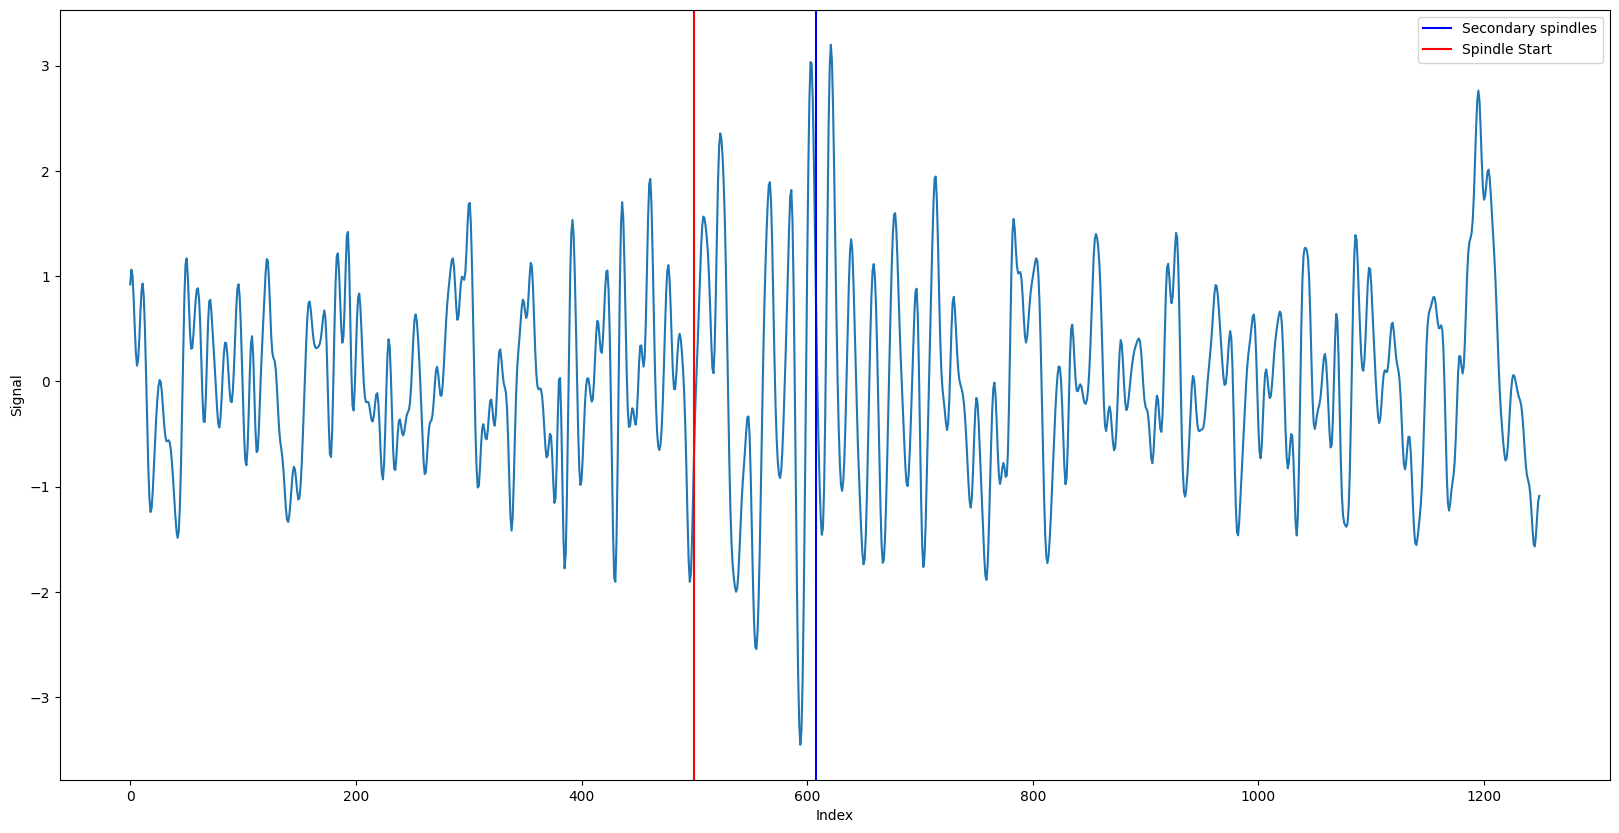

In [61]:
plotter.plot(17, time_before=2, time_after=2)

In [10]:
# Get size in memory of loss
import sys
sys.getsizeof(h1.cov)

72

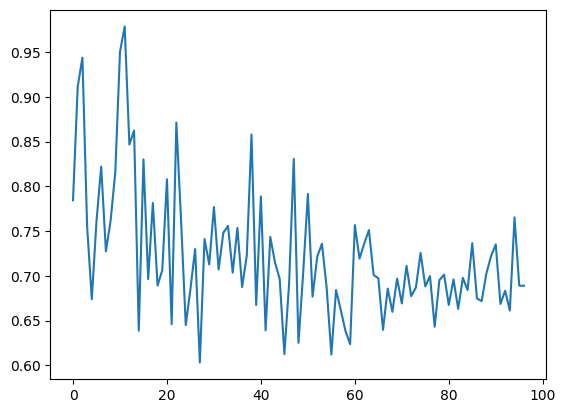

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_stats['loss'])
plt.show()

In [ ]:
rms_scores

[1.7626645637508525,
 0.7516732270416446,
 1.4932201329782764,
 2.1919820585650402,
 1.7306860665794241]

In [ ]:
len(dataset.data)

7224

In [ ]:
rms_scores = np.array(rms_scores)
rms_scores.mean(), rms_scores.std()


(4.084048331035629, 2.9853630907094546)

In [ ]:
sum(rms_scores >= 3) / len(rms_scores)

0.6098901098901099

In [ ]:
real_indexes = np.append(np.zeros(2700), real_indexes)

In [ ]:
labels_real_model = real_indexes >= 0.95

In [ ]:
np.unique(labels_model, return_counts=True)

(array([0., 1.]), array([6407992,  190008]))

In [ ]:
np.unique(labels_real_model, return_counts=True)

(array([False,  True]), array([6406270,  191730]))

In [ ]:
import time

import numpy as np
from portiloop_software.portiloop_python.ANN.adaptation_training import run_adaptation
from portiloop_software.portiloop_python.ANN.data.mass_data import SingleSubjectDataset, SingleSubjectSampler, read_pretraining_dataset
from portiloop_software.portiloop_python.ANN.utils import get_metrics


config['subject_id'] = subject_id

data = read_pretraining_dataset(config['MASS_dir'], patients_to_keep=[subject_id])

assert subject_id in data.keys(), 'Subject not in the dataset'
assert subject_id in labels.keys(), 'Subject not in the dataset'

dataset = SingleSubjectDataset(config['subject_id'], data=data, labels=labels, config=config, ss_labels=ss_labels)  
sampler = SingleSubjectSampler(len(dataset), config['seq_stride'])
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=1, 
    sampler=sampler, 
    num_workers=0)

# Run the adaptation
# start = time.time()
# # run_adaptation(dataloader, net, device, config)
# output_total, window_labels_total, loss, net_copy = run_adaptation(dataloader, net, device, config, train)
# end = time.time()
# print('Time: ', end - start)

# print("Distribution of the predictions:")
# print(np.unique(output_total.cpu().numpy(), return_counts=True))
# print("Distribution of the labels:")
# print(np.unique(window_labels_total.cpu().numpy(), return_counts=True))

# # Get the metrics
# acc, f1, precision, recall = get_metrics(output_total, window_labels_total)

Number of spindles: 73
Number of spindle labels: 12410
len of full signal: 6598000
Length of sampler: 157094
Doing index: 0/157094
Doing index: 10000/157094
Doing index: 20000/157094
Doing index: 30000/157094
Doing index: 40000/157094
Doing index: 50000/157094
Doing index: 60000/157094
Doing index: 70000/157094
Doing index: 80000/157094
Doing index: 90000/157094
Doing index: 100000/157094
Doing index: 110000/157094
Doing index: 120000/157094
Doing index: 130000/157094
Doing index: 140000/157094
Doing index: 150000/157094
Time:  239.07770156860352
Distribution of the predictions:
(array([0., 1.], dtype=float32), array([152570,   4524]))
Distribution of the labels:
(array([0., 1.], dtype=float32), array([156799,    295]))


In [ ]:
labels_model = np.repeat(output_total.cpu().numpy(), 42)
labels_model = np.append(labels_model, np.zeros(52))

In [ ]:
old_indexes = labels_model == 1

array([False, False, False, ..., False, False, False])

In [ ]:
old_indexes = np.where(old_indexes)[0]

In [ ]:
old_indexes = old_indexes[np.insert(np.diff(old_indexes) > 100, 0, True)]

In [ ]:
old_indexes.shape

(1695,)

In [ ]:
labels_model = np.diff(labels_model)
labels_model[labels_model == -1] = 0

(6598000,)

In [ ]:
rms_scores = torch.tensor(rms_scores)
rms_scores.mean(), rms_scores.std()

/tmp/ipykernel_391917/4203616244.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rms_scores = torch.tensor(rms_scores)


(tensor(3.4736, dtype=torch.float64), tensor(2.4870, dtype=torch.float64))

In [ ]:
sum(rms_scores > 2) / len(rms_scores)

tensor(0.6690)